# Appendix A - Supporting Python Code

## 1) Clustering

### 1.1) Loading The Corpus

Let's begin by importing our corpus - the dataset of moview reviews.

In [43]:
# Import relevant packages
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

In [2]:
# Complete NLTK Downloads
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [3]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.1.2


In [4]:
# Suppress Warning Messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
# Create corpus dataframe

# Create Document class
@dataclass
class Document:
    doc_id: str
    text: str

def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

# Define documents in this new class
corpus_df = get_corpus_df('MSDS453_ClassCorpus_Final_Sec56_v4_20230702.csv')
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

### 1.2) Exploratory Data Analysis

Having imported the corpus of movie reviews, let's conduct exploratory data analysis on the raw dataset.

In [6]:
corpus_df.shape

(190, 9)

In [7]:
corpus_df.head(4).T

Doc_ID,101,102,103,104
DSI_Title,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant,SAR_Doc4_Covenant
Submission File Name,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant,SAR_Doc4_Covenant
Student Name,SAR,SAR,SAR,SAR
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Covenant,Covenant,Covenant,Covenant
Text,Nearly two years after the American military w...,Have Guy Ritchie and Jake Gyllenhaal switched ...,Guy Ritchie's The Covenant notably marks the f...,"In a weird throwback to those Chuck Norris ""Mi..."
Descriptor,Action_Covenant_N_101,Action_Covenant_N_102,Action_Covenant_N_103,Action_Covenant_N_104
Doc_ID,101,102,103,104


In [8]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 101 to 217
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 190 non-null    object
 1   Submission File Name      190 non-null    object
 2   Student Name              190 non-null    object
 3   Genre of Movie            190 non-null    object
 4   Review Type (pos or neg)  190 non-null    object
 5   Movie Title               190 non-null    object
 6   Text                      190 non-null    object
 7   Descriptor                190 non-null    object
 8   Doc_ID                    190 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 14.8+ KB
None


In [9]:
print(corpus_df['Movie Title'].unique())

['Covenant' 'Inception' 'No time to die' 'Taken' 'The Dark Knight Rises'
 'Despicable Me 3' 'Holmes and Watson' 'Legally Blonde' 'Lost City'
 'Sisters' 'Drag Me to Hell' 'Fresh' 'It Chapter Two' 'The Toxic Avenger'
 'US' 'Annihilation' 'Minority Report' 'Oblivion' 'Pitch Black']


In [10]:
# Gather the number of reviews by genre
counts_df = corpus_df[['Genre of Movie']].copy()
counts_df['Count'] = 1
counts_df.groupby(['Genre of Movie']).count().reset_index()

,Genre of Movie,Count
0,Action,50
1,Comedy,50
2,Horror,50
3,Sci-Fi,40


In [11]:
corpus_df.columns

Index(['DSI_Title', 'Submission File Name', 'Student Name', 'Genre of Movie',
       'Review Type (pos or neg)', 'Movie Title', 'Text', 'Descriptor',
       'Doc_ID'],
      dtype='object')

### 1.3) Data Wrangling And Vectorization 

#### 1.3.1) Data Wrangling and Vectorization Method 1

In [12]:
def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, sisters_doc_ids: List[int], comedy_doc_ids: List[int]):
    data['is_sisters'] = data.index.isin(sisters_doc_ids)
    data['is_comedy'] = data.index.isin(comedy_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text_disabled(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix

    # https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
    #words = Tfidf.get_feature_names() # For sklearn <= 0.24.x
    #matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

    words = Tfidf.get_feature_names_out() # For sklearn >= 1.0.x
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

In [14]:
#adding two columns to the dataframe to store the processed text and tokenized text
corpus_df['processed_text'] = corpus_df['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in corpus_df['processed_text'].tolist()]
titles = corpus_df['DSI_Title'].tolist()
processed_text = corpus_df['processed_text'].tolist()

In [15]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

In [16]:
tfidf_matrix

,aardman,aaron,abandon,abandoned,abandonment,abandons,abdicate,abdicating,abduct,abducted,...,zimmer,zimmers,zingers,zingy,zippier,zippy,zolfaghari,zombie,zoomy,zzzzs
SAR_Doc1_Covenant,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAR_Doc2_Covenant,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAR_Doc3_Covenant,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAR_Doc4_Covenant,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAR_Doc5_Covenant,0.0,0.0,0.0,0.099853,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OSO_Doc3_PitchBlack,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OSO_Doc4_PitchBlack,0.0,0.0,0.0,0.063045,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OSO_Doc5_PitchBlack,0.0,0.0,0.0,0.057051,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OSO_Doc6_PitchBlack,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 1.3.2) Data Wrangling and Vectorization Method 2

#### 1.3.3) Data Wrangling and Vectorization Method 3

### 1.4) Clustering Experiments

#### 1.4.1) K-Means Clustering Experiments

Let's conduct our first clustering experiments via K-Means Clustering to determine whether we can successfully cluster movie reviews based on review type, genre, or movie title.

Doc_ID
101    0
102    0
103    0
104    0
105    0
      ..
213    1
214    1
215    1
216    1
217    1
Name: Review Type (pos or neg), Length: 190, dtype: int64


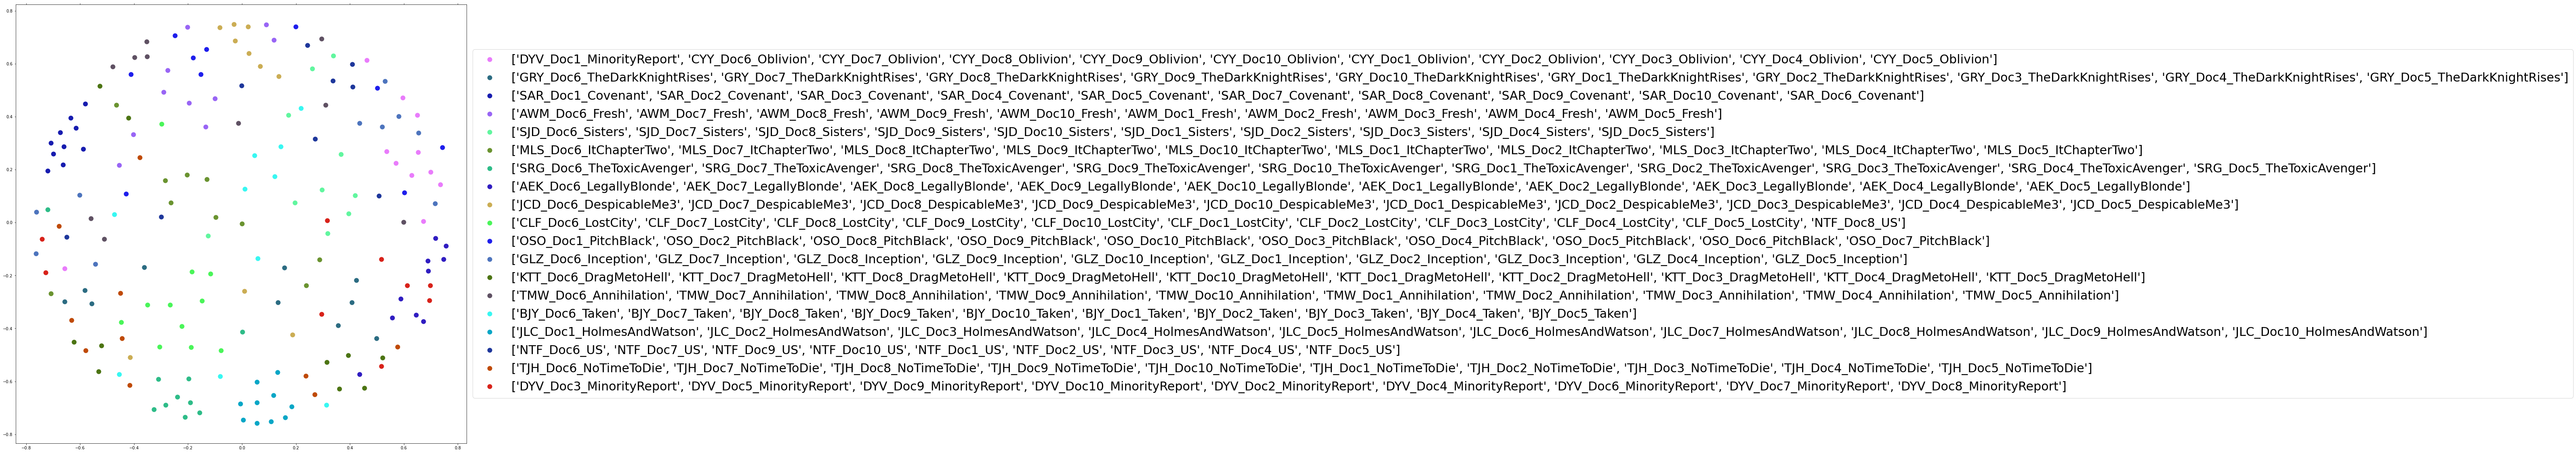

In [31]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame


def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point



#tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=19)

cluster_title[9]

plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

review_type_labels = corpus_df['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(review_type_labels)

#### 1.4.2) Hierarchical Clustering Experiments

In [ ]:
########################### THIS MAY BE A STRETCH GOAL SECTION ################################################

#### 1.4.3) DBSCAN Clustering Experiments

In [ ]:
################################ THIS MAY BE A STRETCH GOAL SECTION ##########################################

## 2) Sentiment Analysis

Let's examine the effectiveness of various classification algorithms for conducting sentiment analysis on our corpus.  We can leverage Random Forest Classification, Naive Bayes Classification, and Support Vector Machine Classification to predict which reviews are positive or negative.

### 2.1) Random Forest Classifier Experiments

Let's apply random forest classification to our corpus to see how effectively we can predict which reviews are positive or negative.

Random Forest Classifier
Accuracy =  36.8 %
F1 Score =  0.368
 
Confusion Matrix


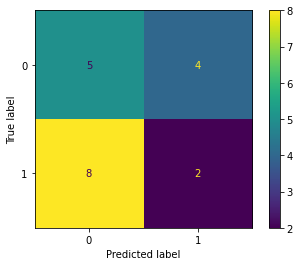

In [52]:
def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("Support Vector Machine Classifier")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic Regression Classifier")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("Naive Bayes Classifier")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("Random Forest Classifier")
        model = RandomForestClassifier()
        
        # Calculate feature importances
        importances = model.feature_importances_

        # Visualize Feature Importance
        # Sort feature importances in descending order
        indices = np.argsort(importances)[::-1]

        # Rearrange feature names so they match the sorted feature importances
        names = [gbtrees_X.columns[i] for i in indices]

        plt.figure(figsize = (12, 5))
        sns.set_style("whitegrid")
        chart = sns.barplot(x = names, y=importances[indices])
        plt.xticks(rotation=45, horizontalalignment='right', fontweight='light')
        plt.title('Random Forest Classifier Feature importance')
        plt.tight_layout()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=23)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions) 
    F1_Score = f1_score(y_test, predictions, average = 'micro')
    print("Accuracy = ", round(100*accy,1), "%")
    print("F1 Score = ", round(F1_Score,3))
    print(" ")
    print("Confusion Matrix")
    
    # Create the confusion matrix of the predictions
    cm = confusion_matrix(y_test, predictions)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot();

classifiers(tfidf_matrix, review_type_labels, 'randomforest')

Doc_ID
101    0
102    0
103    0
104    0
105    0
      ..
213    1
214    1
215    1
216    1
217    1
Name: Review Type (pos or neg), Length: 190, dtype: int64

### 2.2) Naive Bayes Classifier Experiments

Let's apply Naive Bayes Classificaiton to our corpus to determine how effectively we can predict which reviews are positive or negative.

naive_bayes
Accuracy =  36.8 %
F1 Score =  0.368


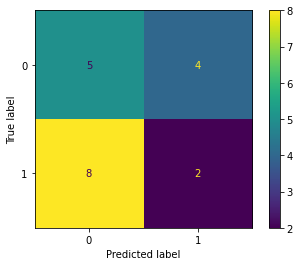

In [45]:
classifiers(tfidf_matrix, review_type_labels, 'naive_bayes')

### 2.3) Support Vector Machine Classification Experiments

Let's apply Support Vector Machine Classification to our corpus to determine how effectively we can predict which reviews are positive or negative.

svm
Accuracy =  47.4 %
F1 Score =  0.474


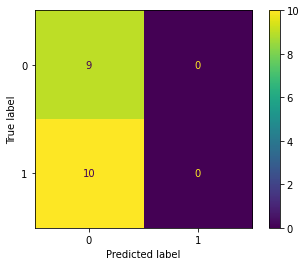

In [46]:
classifiers(tfidf_matrix, review_type_labels, 'svm')

## 3) Multi-Class Classification

Let's apply various classification algorithms to our corpus to determine whether Random Forest Classification, Naive Bayes Classification, or Support Vector Machine Classification perform well at predicting movie genre using movie review data.

### 3.1) Random Forest Classifier Experiments

Let's apply Random Forest Classification to our corpus to predict genre based on the movie review data.

randomforest
Accuracy =  100.0 %
F1 Score =  1.0


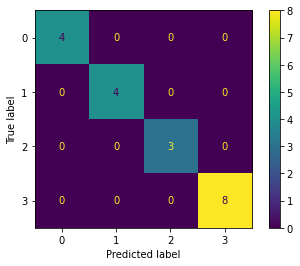

In [47]:
genre_labels = corpus_df['Genre of Movie']

classifiers(tfidf_matrix, genre_labels, 'randomforest')

### 3.2) Naive Bayes Classifier Experiments

Let's apply Naive Bayes Classification to our corpus to examine how well we can predict movie genre based on the movie review.

naive_bayes
Accuracy =  100.0 %
F1 Score =  1.0


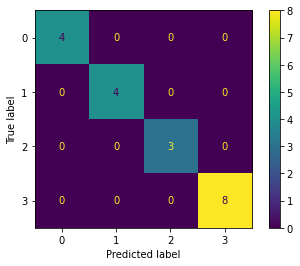

In [48]:
classifiers(tfidf_matrix, genre_labels, 'naive_bayes')

### 3.3) Support Vector Machine Experiments

Let's apply Support Vector Machine Classification to our corpus data to examine how well we can predict movie genre using the movie review data.

svm
Accuracy =  100.0 %
F1 Score =  1.0


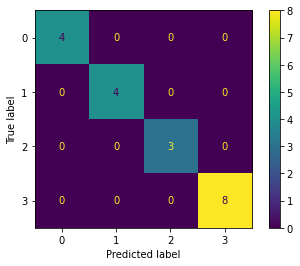

In [49]:
classifiers(tfidf_matrix, genre_labels, 'svm')

## 4) Topic Modeling

### 4.1) Latent Semantic Analysis Experiments

### 4.2) Latent Dirichlet Allocation Experiments